In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from cvxopt import matrix, solvers

# 1. Generate Synthetic Data
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, class_sep=1.5, random_state=42)
y = np.where(y == 0, -1, 1)  # Convert to -1, 1 for SVM compatibility

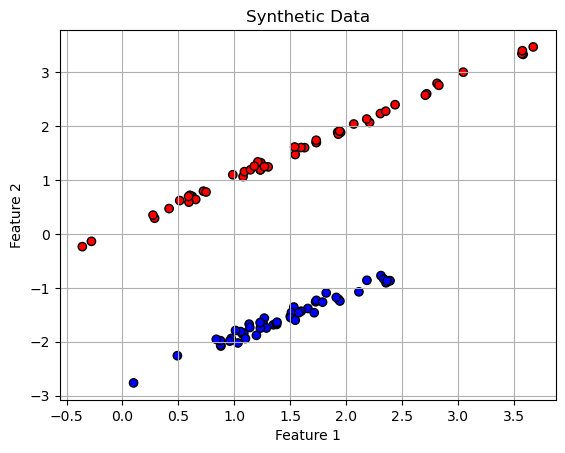

In [6]:
# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
plt.title("Synthetic Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

In [7]:
# 2. Using Scikit-learn for SVMs
print("=== SVM using Scikit-learn ===")
svc = SVC(kernel='linear', C=1.0)
svc.fit(X, y)
y_pred = svc.predict(X)
print(classification_report(y, y_pred))

=== SVM using Scikit-learn ===
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



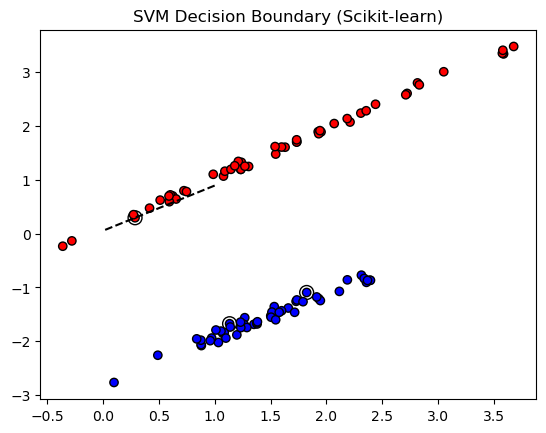

In [9]:
# Plot decision boundary
def plot_sklearn_boundary(clf, X, y):
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid
    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = np.linspace(ylim[0], ylim[1], 50)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Plot
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
               s=100, linewidth=1, facecolors='none', edgecolors='k')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
    ax.set_title("SVM Decision Boundary (Scikit-learn)")

plt.figure()
plot_sklearn_boundary(svc, X, y)
plt.show()

In [13]:
# 3. Custom Linear SVM using cvxopt
class CustomLinearSVM:
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Compute Gram matrix
        K = np.dot(X, X.T)
        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        A = matrix(y.astype('double'), (1, n_samples))
        b = matrix(0.0)

        G_std = np.diag(np.ones(n_samples) * -1)
        h_std = np.zeros(n_samples)

        G_slack = np.identity(n_samples)
        h_slack = np.ones(n_samples) * self.C

        G = matrix(np.vstack((G_std, G_slack)))
        h = matrix(np.hstack((h_std, h_slack)))

        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(solution['x'])

        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.support_vectors_ = X[sv]
        self.support_vector_labels = y[sv]

        self.w = np.sum(self.alphas[:, None] * self.support_vector_labels[:, None] * self.support_vectors_, axis=0)
        self.b = np.mean(
            self.support_vector_labels - np.dot(self.support_vectors_, self.w)
        )

    def project(self, X):
        return np.dot(X, self.w) + self.b

    def predict(self, X):
        return np.sign(self.project(X))


In [14]:
# Train custom linear SVM
print("\n=== Custom Linear SVM using cvxopt ===")
custom_svm = CustomLinearSVM(C=1.0)
custom_svm.fit(X, y)
custom_preds = custom_svm.predict(X)
print(classification_report(y, custom_preds))


=== Custom Linear SVM using cvxopt ===
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



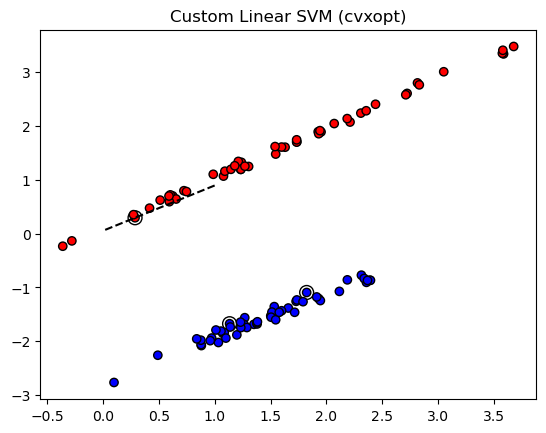

In [16]:
 #Plot decision boundary for custom SVM
def plot_custom_boundary(svm, X, y):
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = np.linspace(ylim[0], ylim[1], 50)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = svm.project(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
               s=100, linewidth=1, facecolors='none', edgecolors='k')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
    ax.set_title("Custom Linear SVM (cvxopt)")

plt.figure()
plot_custom_boundary(custom_svm, X, y)
plt.show()

=== SVM with RBF Kernel (Scikit-learn) ===
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



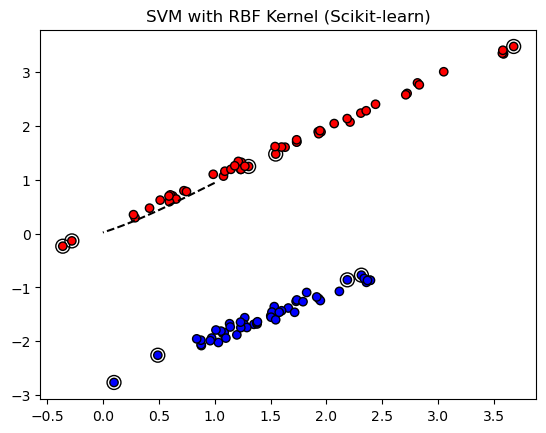

In [17]:
# 4. Using Kernel Methods with Scikit-learn
print("=== SVM with RBF Kernel (Scikit-learn) ===")
rbf_svc = SVC(kernel='rbf', C=1.0, gamma='scale')
rbf_svc.fit(X, y)
rbf_pred = rbf_svc.predict(X)
print(classification_report(y, rbf_pred))

plt.figure()
plot_sklearn_boundary(rbf_svc, X, y)
plt.title("SVM with RBF Kernel (Scikit-learn)")
plt.show()